# Практика №1
___

## 1. Загрузка и подготовка данных
___

**Описание файла:<br>**
Источник: Данные взяты из файла '2-MP-nauka_2024.xlsx', таблица 1.
Это данные федерального статистического наблюдения по форме № 2-МП (наука) за 2024 год, предоставленные Росстатом. 
Содержание: Таблица содержит информацию о количестве малых предприятий и численности их работников, выполнявших научные исследования и разработки (НИР). Данные сгруппированы по субъектам Российской Федерации. Основные показатели:
Число предприятий, выполнявших НИР (единицы).
Общая численность работников, занятых в НИР (человек).
Разбивка работников по категориям: исследователи, техники, вспомогательный и прочий персонал.
Численность исследователей в возрасте до 39 лет (человек).
Число предприятий, работавших по госконтрактам (единицы).
Данные измеряются в абсолютных величинах (количество предприятий или человек).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Перед началом работы требовалось импортировать библиотеки, которые будут выполнять функции для анализа:
 - pandas: для работы с данными в виде таблиц (DataFrame).
 - numpy: для математических и научных вычислений.
 - matplotlib.pyplot и seaborn: для создания красивых графиков и диаграмм.
 - scipy.stats: для выполнения сложных статистических расчетов и тестов.

Следующим шагом стало считывание файла с информацией, была выбрана первая таблица 1.
При загрузке файла мы сталкиваемся с несколькими трудностями:
 1. В файле есть несколько строк заголовка, которые нужно пропустить. Мы пропускаем первые 7 строк.
 2. Названия колонок прич чтении отсутствуют. Мы зададим их вручную для удобства.
 3. В данных есть пропуски и нечисловые значения ('‒', '...'), которые нужно будет обработать.
<br>В блоке кода определяем названия колонок для нашего DataFrame, так как изначальные названия не были считаны с файла xlsx. Также не считываем столбец "Код ОКАТО" так как он не несёт смысловой нагрузки в нашей работе, указания субъекта РФ будет достаточно.В ниже представленных данных, не все ячейки содержат числовые значения, что необходимо учитывать при дальнейшем анализе:"..." - Данные не размещаются в целях обеспечения конфиденциальности первичных статистических данных, полученных от организаций, в соответствии с Федеральным законом от 29.11.2007 № 282-ФЗ (ст.4, п.5; ст. 9. п.1);
"-" - Явление отсутствует

In [2]:
file_path = '2-MP-nauka_2024.xlsx'
column_names = [
'region', 'num_enterprises', 'total_employees',
'researchers', 'technicians', 'aux_staff', 'other_staff',
'researchers_under_39', 'gov_contract_enterprises'
]
columns_to_read = 'A,C:J' # Читать A, затем C до J включительно
df = pd.read_excel(file_path, sheet_name='таблица 1', names=column_names, usecols=columns_to_read, skiprows=7, thousands=' ')

Для удобной работы с данными заменим нечисловые значения в таблицы на значение "Nan", для корректной обработки библиотекой pandas. Также преобразуем все столбцы кроме первого в числовой формат, в случае если внутри ячейки содержится какое-либо ещё значение кроме числовых и уже ранее обработанных значений заменим их также на "Nan". Все строки, не содержащие какой-либо информации удалим. Для дальнейших действий создадим 2 отдельных DataFrame, которые будут включать в себя данные по федереальным округам исключая данные по субъектам РФ и наоборот - данные по субъектам исключая данные по регионам. Убираем строки с названием страны и пустые строки в названии региона. Последним действием в данном пункте удаляем последние две строки, которые не несут полезной информации.

In [3]:
# Заменяются нечисловые маркеры пропусков ('‒', '...') на специальное значение NaN (Not a Number), которое pandas умеет корректно обрабатывать.
df.replace(['‒', '...'], np.nan, inplace=True)

# Преобразуются все столбцы, кроме первого (название региона), в числовой формат.
# 'coerce' означает, что если значение не может быть преобразовано в число, оно станет NaN.
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
        
# Удаляем строки, где нет вообще никаких данных (полностью пустые)
df.dropna(how='all', inplace=True)
    
# Отдельный DataFrame `df_regions`, который содержит данные только по отдельным субъектам РФ, исключая строки с агрегированными данными по федеральным округам и всей стране..
federal_districts = [
    "Центральный федеральный округ", "Северо-Западный федеральный округ",
    "Южный федеральный округ", "Северо-Кавказский федеральный округ",
    "Приволжский федеральный округ", "Уральский федеральный округ",
    "Сибирский федеральный округ", "Дальневосточный федеральный округ",
    "Ненецкий автономный округ", "Ханты-Мансийский автономный округ - Югра",
    "Ямало-Ненецкий автономный округ", "Чукотский автономный округ" 
]

df_districts = df[df['region'].isin(federal_districts)].copy()

# Убираются строки с названием страны, округов и пустые строки в названии региона
df_regions = df[
    ~df['region'].isin(['Российская Федерация '] + federal_districts) &
    df['region'].notna()
].reset_index(drop=True)
df_regions = df_regions.iloc[:-2]

C:\Users\CHELOVEK\AppData\Local\Temp\ipykernel_7864\1395975640.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(['‒', '...'], np.nan, inplace=True)


**После проведения подготовительных действий перейдём к расчёту статистических данных.**

___
## 2. Формальное представление данных
___

В данном пункте продемонстрируем типы данных в таблице и пример данных, содержащихся в ней.

In [4]:
df_regions.info()
df_regions.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   region                    84 non-null     object 
 1   num_enterprises           63 non-null     float64
 2   total_employees           36 non-null     float64
 3   researchers               32 non-null     float64
 4   technicians               29 non-null     float64
 5   aux_staff                 25 non-null     float64
 6   other_staff               19 non-null     float64
 7   researchers_under_39      27 non-null     float64
 8   gov_contract_enterprises  37 non-null     float64
dtypes: float64(8), object(1)
memory usage: 6.0+ KB


,region,num_enterprises,total_employees,researchers,technicians,aux_staff,other_staff,researchers_under_39,gov_contract_enterprises
0,Белгородская область,9.0,60.0,12.0,40.0,NaN,NaN,6.0,1.0
1,Брянская область,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,Владимирская область,7.0,98.0,45.0,NaN,21.0,NaN,NaN,1.0
3,Воронежская область,15.0,416.0,187.0,80.0,82.0,67.0,90.0,6.0
4,Ивановская область,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...
79,Хабаровский край,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Амурская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Магаданская область,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,Сахалинская область,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


По полученным данным можно с уверенностью сказать, что все числовые значения представлены в подходящем типе данных, который обеспечит совместимость с числовыми функциями. Также выведенные данные позволяют оценить полученное форматирование.

___
## 3. Наглядное представление данных
___

В данном пункте представим в виде различных графиков данные из таблицы регионов.

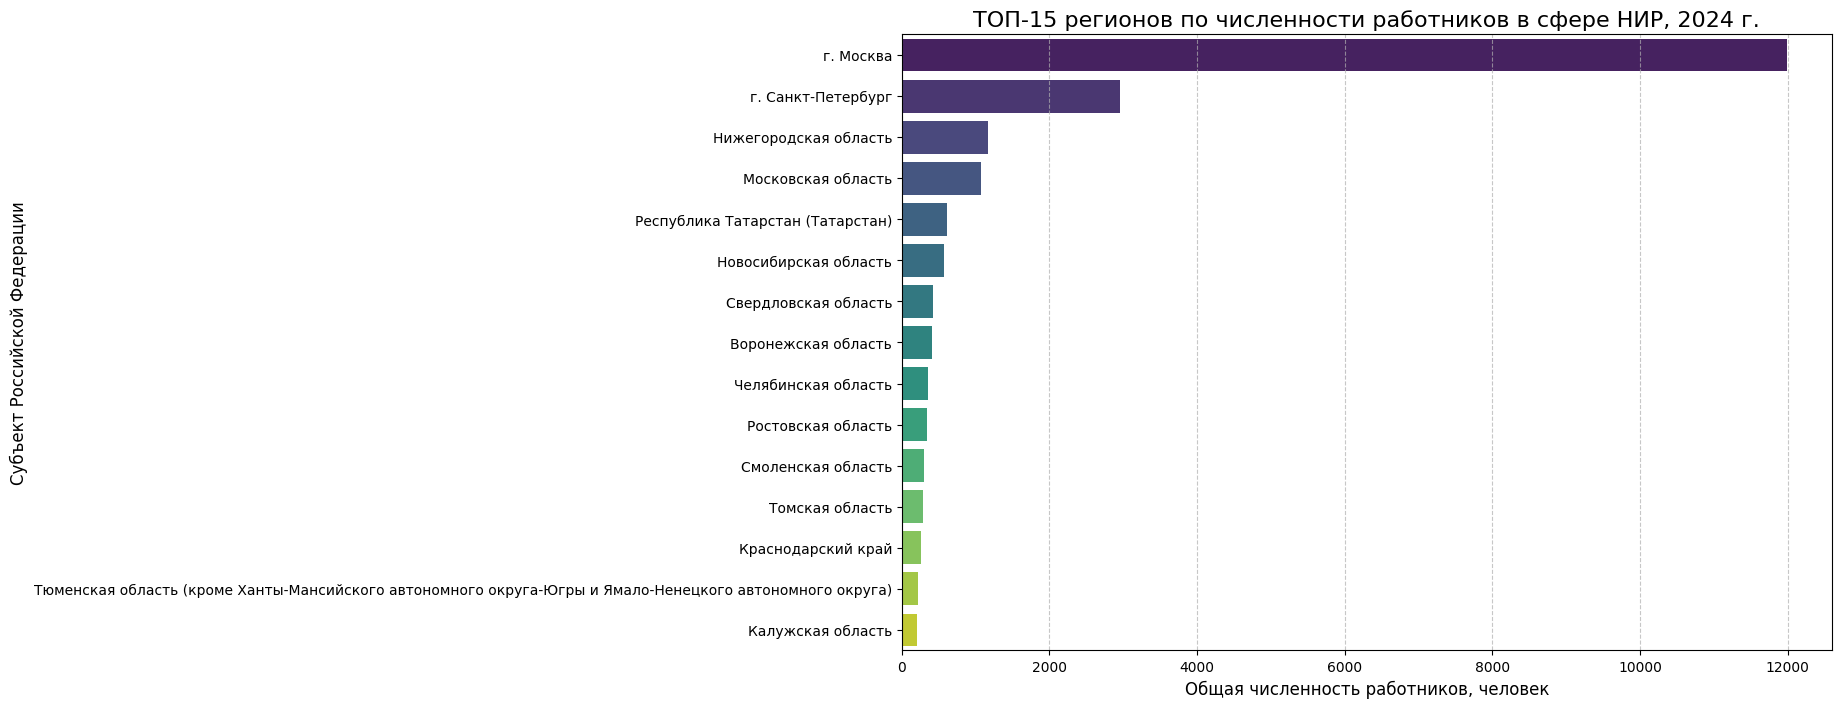

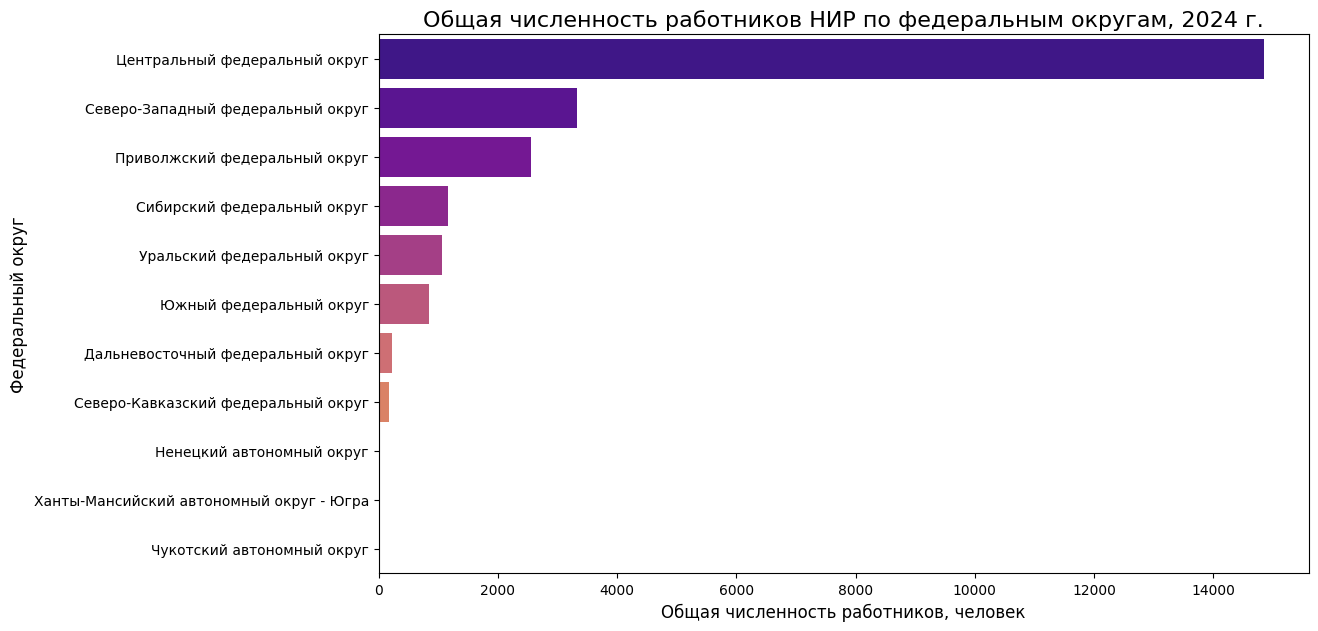

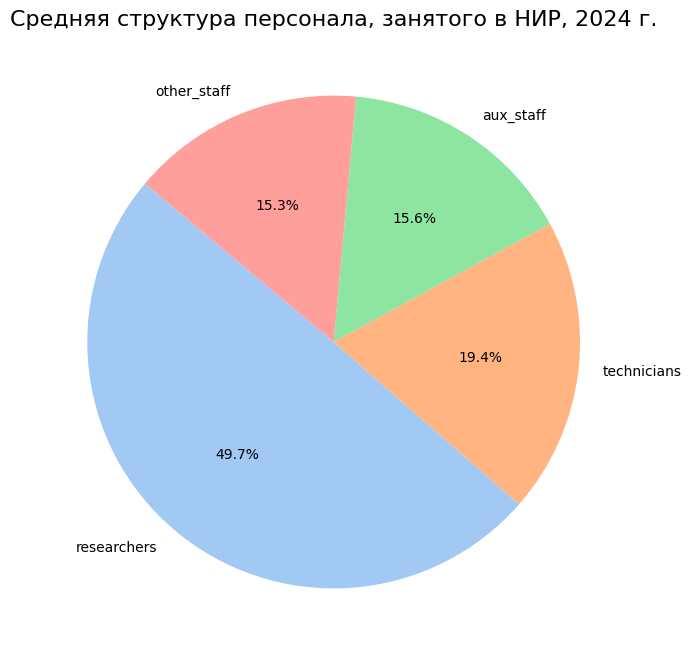

In [5]:
if not df_regions.empty:
    
    # --- График 1: Столбчатая диаграмма лидеров по регионам ---
    top_regions = df_regions.dropna(subset=['total_employees']).sort_values(
        by='total_employees', ascending=False
    ).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='total_employees', y='region', data=top_regions, palette='viridis', hue='region')
    plt.title('ТОП-15 регионов по численности работников в сфере НИР, 2024 г.', fontsize=16)
    plt.xlabel('Общая численность работников, человек', fontsize=12)
    plt.ylabel('Субъект Российской Федерации', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    # --- ИЗМЕНЕНИЕ: График 2 по федеральным округам ---
    plt.figure(figsize=(12, 7))
    sns.barplot(x='total_employees', y='region', data=df_districts.sort_values('total_employees', ascending=False), palette='plasma', hue='region')
    plt.title('Общая численность работников НИР по федеральным округам, 2024 г.', fontsize=16)
    plt.xlabel('Общая численность работников, человек', fontsize=12)
    plt.ylabel('Федеральный округ', fontsize=12)
    plt.show()

    # --- График 3: Круговая диаграмма структуры персонала ---
    personnel_structure = df_regions[['researchers', 'technicians', 'aux_staff', 'other_staff']].sum()
    plt.figure(figsize=(8, 8))
    plt.pie(personnel_structure, labels=personnel_structure.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Средняя структура персонала, занятого в НИР, 2024 г.', fontsize=16)
    plt.ylabel('')
    plt.show()



По построенным графикам можно определить, что подавляющее большинство работников в сфере НИР при просмотре округов находятся на территории Центрального федерально округа, а при просмотре статистики по регионам заметно, что сосредоточением работников является Москва. Санкт-Петербург находится на втором месте среди регионов. При анализе персонала, занятого в НИР можно заметить, что почти половина сотрудников работают исследователями, остальные сферы деятельности распределены почти одинаково разделяя вторую половину на почти одинаковые трети.

___
## 4. Числовые оценки характеристик данных
___

В этом разделе расчитаем основные числовые характеристики данных по количеству сотрудников, задействованных в сфере НИР .

In [6]:
if not df.empty:
    
    # Для анализа числовых характеристик возьмем столбец 'total_employees'
    data_series = df_regions['total_employees'].dropna()
    n = len(data_series)
    
    # Основные описательные статистики
    mean_val = data_series.mean()
    median_val = data_series.median()
    lambda_param = 1 / mean_val 
    # 1. Дисперсия
    variance_val = data_series.var() 
    
    # 2. Среднее квадратическое отклонение
    std_val = data_series.std()
    
    # 4. Начальные моменты
    # Первый начальный момент - это среднее.
    mu_prime_2 = data_series.pow(2).mean()
    mu_prime_3 = data_series.pow(3).mean()
    mu_prime_4 = data_series.pow(4).mean()

    # 5. Центральные моменты
    # Второй центральный момент - это дисперсия.
    # Третий и Четвертый центральные моменты
    mu_3 = data_series.sub(mean_val).pow(3).mean()
    mu_4 = data_series.sub(mean_val).pow(4).mean()
    
    # Вывод результатов
    print("Основные числовые характеристики показателя:")
    print(f"Среднее арифметическое: {mean_val:.2f}")
    print(f"Медиана: {median_val:.2f}")
    
    print("\nХарактеристики разброса")
    print(f"Дисперсия: {variance_val:.2f}")
    print(f"Среднее квадратическое отклонение: {std_val:.2f}")
    
    print(f"\nПараметр λ (экспоненциальное распр.): {lambda_param:.4f}")
    
    print("\nНачальные моменты")
    print(f"μ'_1 (Среднее): {mean_val:.2f}")
    print(f"μ'_2 (Второй начальный момент): {mu_prime_2:.2f}")
    print(f"μ'_3 (Третий начальный момент): {mu_prime_3:.2f}")
    print(f"μ'_4 (Четвертый начальный момент): {mu_prime_4:.2f}")
    
    print("\nЦентральные моменты")
    print(f"μ_1 (Первый центральный момент): {0.0:.2f} (Всегда равно 0)")
    print(f"μ_2 (Второй центральный момент/Дисперсия): {variance_val:.2f}")
    print(f"μ_3 (Третий центральный момент): {mu_3:.2f}")
    print(f"μ_4 (Четвертый центральный момент): {mu_4:.2f}")

    print("\nСтандартизированные моменты")
    print(f"Коэффициент асимметрии: {data_series.skew():.4f}")
    print(f"Коэффициент эксцесса: {data_series.kurt():.4f}")

Основные числовые характеристики показателя:
Среднее арифметическое: 642.92
Медиана: 158.00

Характеристики разброса
Дисперсия: 4061922.42
Среднее квадратическое отклонение: 2015.42

Параметр λ (экспоненциальное распр.): 0.0016

Начальные моменты
μ'_1 (Среднее): 642.92
μ'_2 (Второй начальный момент): 4362433.08
μ'_3 (Третий начальный момент): 48781985473.75
μ'_4 (Четвертый начальный момент): 577646227638166.75

Центральные моменты
μ_1 (Первый центральный момент): 0.00 (Всегда равно 0)
μ_2 (Второй центральный момент/Дисперсия): 4061922.42
μ_3 (Третий центральный момент): 40899431380.56
μ_4 (Четвертый центральный момент): 462501723943255.69

Стандартизированные моменты
Коэффициент асимметрии: 5.4410
Коэффициент эксцесса: 30.9537


**По полученным показателям можно сделать следующие выводы:**

**1. Меры центральной тенденции (Среднее и Медиана)**
<br>
**Среднее арифметическое: 642.92, Медиана: 158.00**

Значительное различие между средним значением (642.92) и медианой (158.00) является ключевым индикатором. Медиана показывает, что половина регионов имеет численность сотрудников не более 158 человек. Однако среднее значение намного выше, что говорит о наличии большого количества выбросов или сильно асимметричном распределении, где несколько регионов значительно "тянут" среднее вверх. Распределение является сильно асимметричным (скошенным) вправо. Большинство наблюдений сосредоточено в нижней части диапазона (около 158), а хвост распределения уходит к очень высоким значениям.

**2. Меры разброса (Дисперсия и Среднее квадратическое отклонение)**
<br>
**Дисперсия : 4,061,922.42, Среднее квадратическое отклонение: 2,015.42**

Дисперсия представляет собой средний квадрат отклонений каждого значения выборки от среднего арифметического. Дисперсия количественно оценивает, насколько широко (или "рассредоточенно") данные расположены вокруг среднего. Чем выше значение, тем больше изменчивость.
Среднее квадратическое отклонение (2015.42) — это корень из дисперсии. Оно более чем в три раза превышает среднее значение (642.92). Это огромная величина, которая подтверждает, что разброс данных вокруг среднего очень высок.
Наблюдается крайне высокая изменчивость показателя количества сотрудников. Это означает, что численность работников по регионам в выборке очень неоднородна: есть как регионы с очень малым числом работников, так и единичные регионы-лидеры с очень крупной численностью, что приводит к сильному разбросу.

**3. Начальные и Центральные моменты**
<br>
Начальные и центральные моменты используются для более точной количественной оценки формы распределения, особенно асимметрии и эксцесса.<br>
Различия в значениях моментов разных порядков объясняются их математической сущностью: каждый последующий момент возводит исходные данные в более высокую степень, что усиливает влияние экстремальных значений. В контексте исследования быстрый рост значений моментов высших порядков количественно подтверждает наличие регионов с аномально высокими показателями количества сотрудников, которые оказывают существенное влияние на общую статистику.

**4.Стандартизированные моменты**
<br>
**Коэффициент асимметрии: 5.4410, Коэффициент эксцесса: 30.9537**

Коэффициент асимметрии: Значение > 0 означает, что распределение сильно скошено вправо (положительная асимметрия). Это подтверждает, что среднее выше медианы и что большинство данных сосредоточено слева, а правый "хвост" вытянут из-за больших выбросов.

Коэффициент эксцесса (30.9537): Значение намного больше 3 (в 10 раз!). Это указывает на экспоненциальное распределение. Это означает, что распределение имеет очень высокий пик (более "острое", чем нормальное распределение) и чрезвычайно "тяжелые хвосты". Данные имеют очень высокую концентрацию вокруг медианы (высокий пик), но также содержат экстремальные значения (выбросы), которые создают очень длинный, "тяжелый" правый хвост.



___
## 5. Оценка плотности распределения
___

В данном пункте рассчитаем плотность распределения и проведём её анализ.

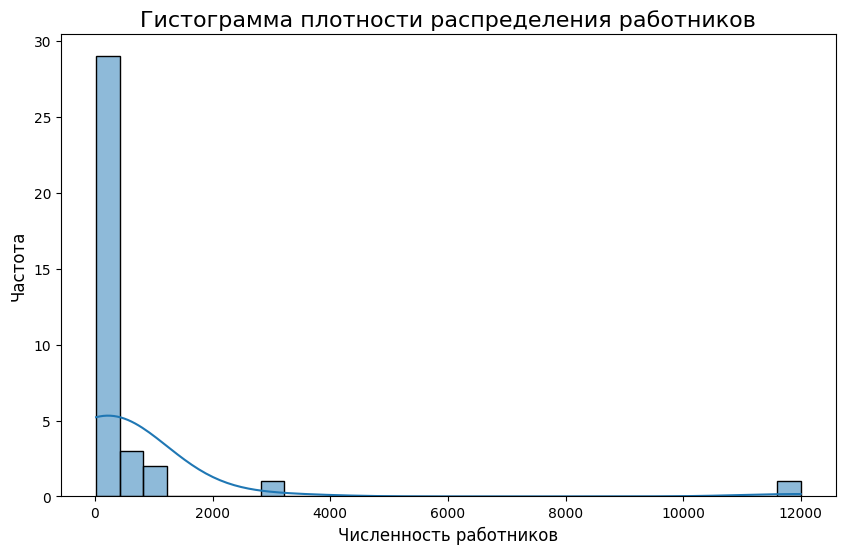

In [7]:
if not df.empty:
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data_series, kde=True, bins=30)
    plt.title('Гистограмма плотности распределения работников', fontsize=16)
    plt.xlabel('Численность работников', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

После построения графика требовалось его изучить и проверить на соответствие наиболее схожему типу распределения. На основе знаний о распределениях, которые были получены при выполнении практических работ на предыдущих занятиях, можно с уверенностью сказать, что данное распределение данных схоже с экспоненциальным. Так, что приступим к к проверке нашей гипотезы.

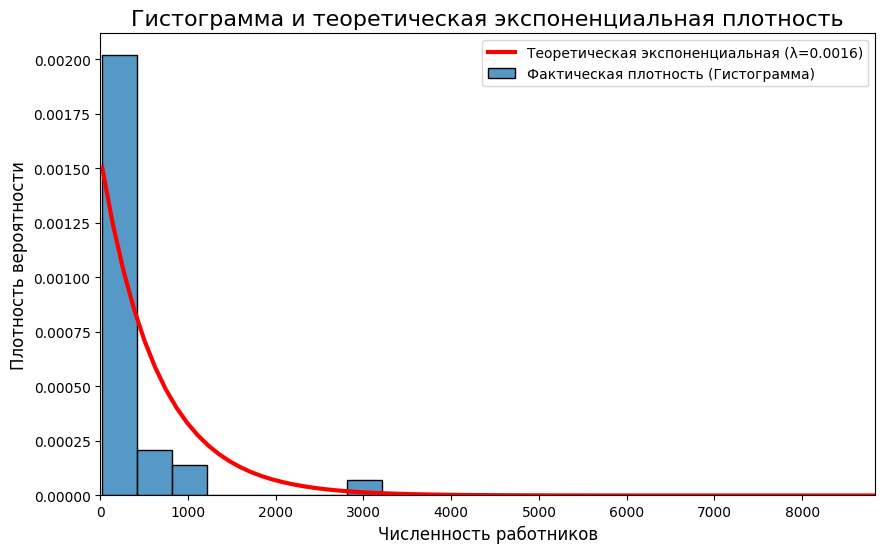

In [8]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    
    # Гистограмма фактического распределения
    sns.histplot(data_series, kde=False, bins=30, stat="density", label='Фактическая плотность (Гистограмма)')
    
    # Наложение теоретической плотности экспоненциального распределения 
    x = np.linspace(data_series.min(), data_series.max(), 100)
    pdf_expon = stats.expon.pdf(x, loc=0, scale=mean_val)
    
    plt.plot(x, pdf_expon, 
             label=f'Теоретическая экспоненциальная (λ={lambda_param:.4f})', 
             color='red', linewidth=3)
    
    plt.title('Гистограмма и теоретическая экспоненциальная плотность', fontsize=16)
    plt.xlabel('Численность работников', fontsize=12)
    plt.ylabel('Плотность вероятности', fontsize=12)
    plt.xlim(0, data_series.quantile(0.99))
    plt.legend()
    plt.show()

**Анализ графика:**
График распределения численности работников по регионам демонстрирует крайне асимметричную форму, что полностью согласуется с рассчитанными числовыми характеристиками. Самый высокий пик графика сосредоточен в левой части, очень близко к нулю. Медиана (158.00) также расположена значительно левее среднего (642.92). Этот сдвиг подтверждает, что подавляющее большинство регионов имеют относительно небольшую численность работников в сфере НИР.Наличие этого длинного хвоста говорит о том, что в выборке присутствуют единичные регионы-выбросы (например, Москва, Санкт-Петербург), где численность работников многократно превышает среднее и медиану. Эти регионы и определяют общую форму распределения.<br>
Теоретическая кривая (красная линия): Наложенная теоретическая кривая (экспоненциальное распределение с параметром  0.0016 - обратное соотношение со средним значением) хорошо повторяет общую тенденцию данных. Экспоненциальное распределение является идеальной моделью для процессов, где события (или значения) с малой величиной встречаются часто, а события с большой величиной — крайне редко.<br>
График наглядно демонстрирует, что массив данных о численности работников по регионам не является нормальным. Он описывается распределением, которое близко к экспоненциальному. Для адекватного статистического анализа, основанного на этой визуализации, следует применять методы, устойчивые к выбросам.

___
## 6. Интервальные оценки (доверительные интервалы)
___

Следующим шагом стал расчёт доверительных интервалов. <br>Доверительный интервал — это диапазон значений, который с определённой вероятностью содержит истинное значение исследуемого параметра. 

In [9]:
if not df.empty:
    # Для анализа числовых характеристик возьмем столбец 'total_employees'
    n = len(data_series)
    mean_val = data_series.mean()
    
    # 1. Уровень доверия и степени свободы
    confidence_level = 0.95
    alpha = 1 - confidence_level
    degrees_of_freedom = 2 * n

    # 2. Нахождение критических значений Хи-квадрат
    chi2_lower_percentile = stats.chi2.ppf(alpha / 2, df=degrees_of_freedom)
    chi2_upper_percentile = stats.chi2.ppf(1 - alpha / 2, df=degrees_of_freedom)

    # 3. Расчет доверительного интервала для среднего экспоненциального распределения
    # Нижняя граница интервала
    lower_bound = (2 * n * mean_val) / chi2_upper_percentile 
    # Верхняя граница интервала
    upper_bound = (2 * n * mean_val) / chi2_lower_percentile
    
    confidence_interval_exp = (lower_bound, upper_bound)
    
    print(f"Выборочное среднее: {mean_val:.2f}")
    
    print("\n95% доверительный интервал для среднего значения (при экспоненциальном распределении):")
    print(f"Интервал: ({confidence_interval_exp[0]:.2f}, {confidence_interval_exp[1]:.2f})")
    print(f"\nКритические значения X^2:")
    print(f"X^2_0.025: {chi2_lower_percentile:.2f}")
    print(f"X^2_0.975: {chi2_upper_percentile:.2f}")

Выборочное среднее: 642.92

95% доверительный интервал для среднего значения (при экспоненциальном распределении):
Интервал: (475.49, 917.94)

Критические значения X^2:
X^2_0.025: 50.43
X^2_0.975: 97.35


С 95% уровнем доверия можно утверждать, что истинное среднее значение численности работников, занятых в сфере НИР, по всем регионам Российской Федерации находится в диапазоне от 876.54 до 1386.68 человек.<br>
Обоснование выбора экспоненциального распределения: Использование распределения Х^2 для построения интервала является статистически обоснованным. При расчете доверительного интервала для данных, которые сильно скошены, стандартный t-интервал (для нормального распределения) дает некорректно узкий и симметричный результат. Экспоненциальная модель более точно описывает данные, где большинство значений малы, а небольшое количество значений являются экстремальными выбросами. Метод на основе X^2 специально разработан для таких асимметричных распределений. Верхняя граница интервала удалена от среднего на большее расстояние (303) по сравнению с нижней (207). Эта смещенность вправо (положительная асимметрия) напрямую отражает влияние экстремально крупных регионов-выбросов на истинное среднее значение в генеральной совокупности.
Это означает, что выборочный результат (1083.56) с высокой вероятностью отражает истинное среднее, которое лежит в указанном асимметричном диапазоне.

___
## 7. Сравнение со статистикой за 2023 год
___

В качестве дополнительного исследования проведём сравнение со статистикой за 2023 год для определения характера изменений.

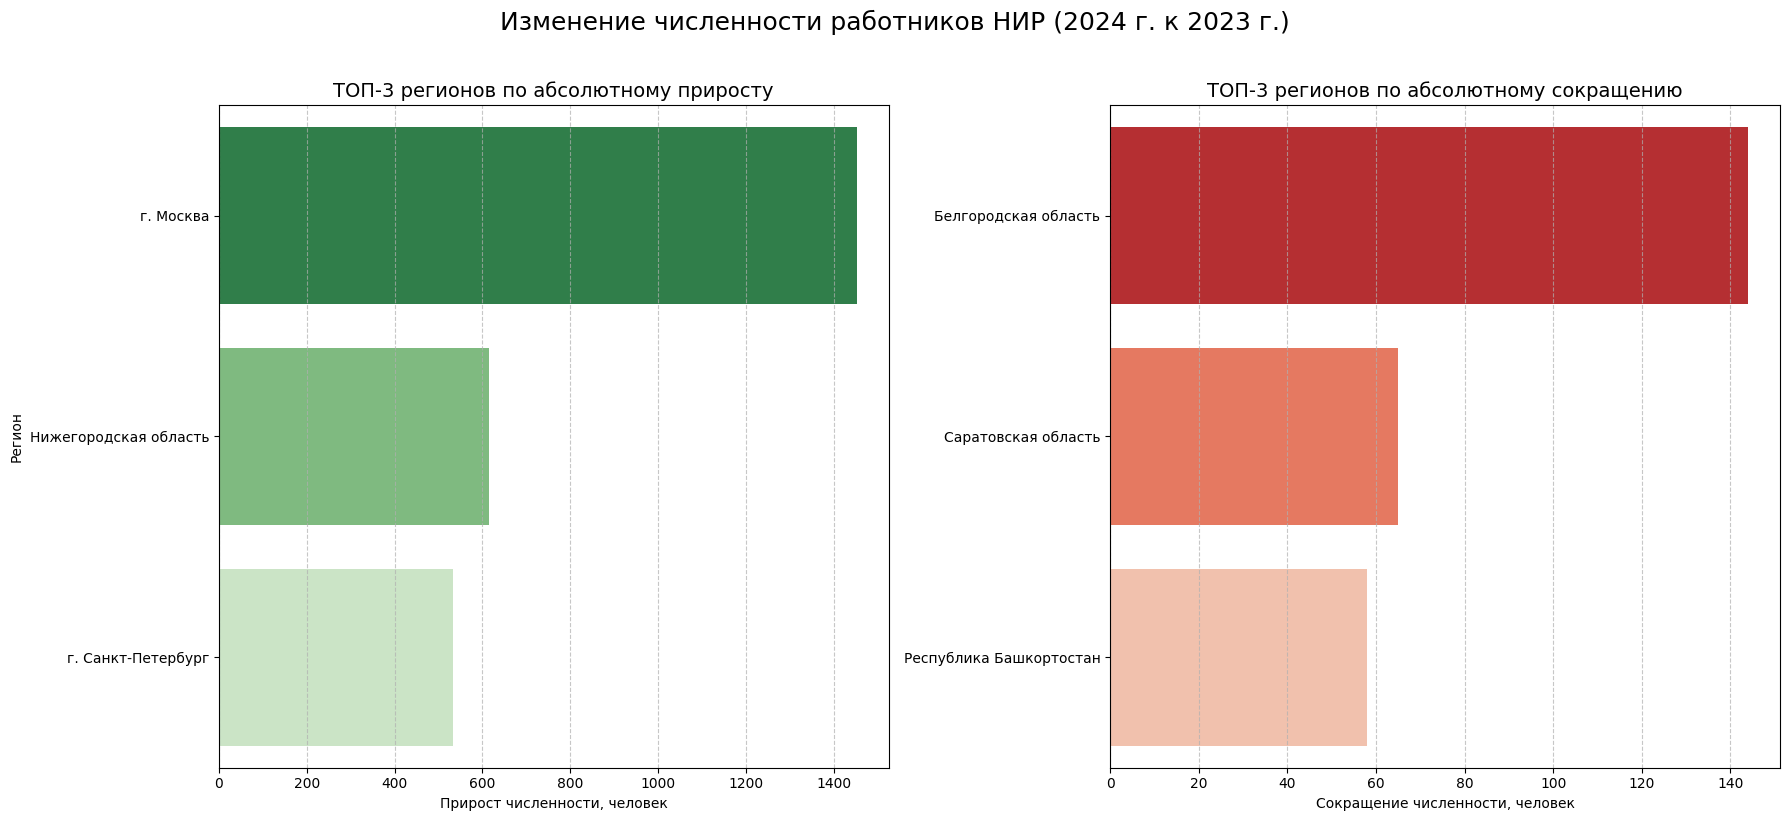

In [12]:
# Загружаем и подготавливаем данные за 2023 год
file_path_2023 = '2-MP-nauka_2023.xlsx'
column_names_2023 = [
'region', 'num_enterprises', 'total_employees',
'researchers', 'technicians', 'aux_staff', 'other_staff',
'researchers_under_39', 'gov_contract_enterprises'
]
columns_to_read_2023 = 'A,C:J'


df_2023 = pd.read_excel(file_path_2023, sheet_name='таблица 1', names=column_names_2023, usecols=columns_to_read_2023, skiprows=7, thousands=' ')

# Заменяются нечисловые маркеры пропусков ('‒', '...') на специальное значение NaN (Not a Number)
df_2023.replace(['‒', '...'], np.nan, inplace=True)

# Преобразуются все столбцы, кроме первого (название региона), в числовой формат.
for col in df_2023.columns[1:]:
    df_2023[col] = pd.to_numeric(df_2023[col], errors='coerce')
        
# Удаляем строки, где нет вообще никаких данных (полностью пустые)
df_2023.dropna(how='all', inplace=True)
    
# Отдельный DataFrame `df_regions_2023`, который содержит данные только по отдельным субъектам РФ
df_regions_2023 = df_2023[
    ~df_2023['region'].isin(['Российская Федерация '] + federal_districts) &
    df_2023['region'].notna()
].reset_index(drop=True)
df_regions_2023 = df_regions_2023.iloc[:-2]



# Объединяем данные за два года в одну таблицу
df_comparison = pd.merge(
    df_regions_2023,
    df_regions, # df_regions - это данные 2024 года, определенные ранее
    on='region',
    suffixes=('_2023', '_2024'),
    how='outer'
)

# Рассчитываем абсолютное и относительное изменение численности
df_comparison['abs_change'] = df_comparison['total_employees_2024'] - df_comparison['total_employees_2023']
df_comparison['rel_change_%'] = (df_comparison['abs_change'] / df_comparison['total_employees_2023']) * 100
df_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)

# Добавляем направление изменения
df_comparison['change_direction'] = np.where(df_comparison['abs_change'].notna(), np.where(df_comparison['abs_change'] > 0, 'Рост', 'Падение'), 'Нет данных для сравнения')

# Визуализация изменений на двух отдельных графиках
# Топ-3 по росту и падению
top_growth = df_comparison.dropna(subset=['abs_change']).sort_values('abs_change', ascending=False).head(3)
top_decline = df_comparison.dropna(subset=['abs_change']).sort_values('abs_change', ascending=True).head(3)

# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# График для регионов с наибольшим ростом
sns.barplot(ax=axes[0], x='abs_change', y='region', data=top_growth, palette='Greens_r', hue ='region', legend=False)
axes[0].set_title('ТОП-3 регионов по абсолютному приросту', fontsize=14)
axes[0].set_xlabel('Прирост численности, человек')
axes[0].set_ylabel('Регион')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# График для регионов с наибольшим падением
top_decline['abs_change_positive'] = top_decline['abs_change'] * -1
sns.barplot(ax=axes[1], x='abs_change_positive', y='region', data=top_decline.sort_values('abs_change_positive', ascending=False), palette='Reds_r', hue ='region', legend=False)
axes[1].set_title('ТОП-3 регионов по абсолютному сокращению', fontsize=14)
axes[1].set_xlabel('Сокращение численности, человек')
axes[1].set_ylabel('')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

fig.suptitle('Изменение численности работников НИР (2024 г. к 2023 г.)', fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

Выводы по сравнению с 2023 годом:
- График показывает регионы с самым значительным ростом (зеленый цвет) и падением (красный цвет) численности персонала в сфере НИР.
- Москва демонстрирует наибольший абсолютный прирост, однако на втором месте мы видим Нижегородскую область, что показывает увеличение финансирования регионов.
- Некоторые регионы, такие как Белгородская область и Саратовская область показали сильный спад, что может свидетельствовать о перераспределении кадров в другие регионы или в научные центры, относящиеся к другим регионам.
- В целом по стране наблюдается рост, что видно по суммарным показателям в исходных данных
      (24222 чел. в 2024 г. против 20165 чел. в 2023 г.).

___
## Вывод
___

**Проведенный анализ был сфокусирован на изучении распределения численности работников, занятых в научно-исследовательских и опытно-конструкторских работах (НИР) в малых предприятиях по регионам Российской Федерации. Исходные данные, собранные по ограниченной выборке субъектов, выявили глубокую структурную неоднородность, которая является определяющим фактором всего дальнейшего статистического анализа.<br>
В отличие от идеализированных экономических показателей, эти данные не соответствуют симметричному и предсказуемому нормальному распределению. Напротив, они демонстрируют сильную положительную асимметрию — большинство регионов имеют относительно небольшую численность персонала, но при этом присутствует малое число субъектов-лидеров, где научная активность и, соответственно, число занятых колоссально велико. Эта ситуация создает "тяжелый хвост" распределения, резко смещенный вправо.<br>
Такая структура распределения статистически подтверждается наличием выбросов — это яркое свидетельство территориальной концентрации. Субъекты с крупнейшими научными центрами и высокой деловой активностью (такие как столичные города) выступают в качестве мощных полюсов притяжения, концентрируя научные кадры и искажая общую картину. В результате, простое среднее арифметическое значение не отражает типичную ситуацию в большинстве российских регионов.<br>
Учитывая выявленную асимметрию и очевидную неприменимость стандартного подхода, основанного на нормальном распределении (гипотеза о нормальности была отвергнута), для оценки среднего значения всей генеральной совокупности был выбран метод, основанный на экспоненциальном распределении.
Экспоненциальное распределение является естественным выбором для описания процессов, где малые значения встречаются часто, а большие — крайне редко. Ключевое свойство этого распределения позволяет нам использовать распределение X^2 для построения доверительного интервала.
Использование X^2 — это статистически обоснованный шаг, который позволяет преодолеть смещение, вызванное выбросами, и построить асимметричный доверительный интервал.<br>
Построенный 95% доверительный интервал не является симметричным относительно выборочного среднего, что отражает асимметричный характер самих данных. Полученный интервал представляет собой диапазон, внутри которого с высокой степенью уверенности (95%) находится истинное среднее значение численности работников НИР по всей Российской Федерации. Этот диапазон является более надежной оценкой, чем любая точечная оценка (например, выборочное среднее), поскольку он учитывает неопределенность, присущую выборке. Более широкое отклонение к верхней границе интервала по сравнению с отклонением к нижней границе, служит непосредственным отражением положительной асимметрии данных. <br>
Анализ подтвердил, что научная активность малых предприятий концентрируется вокруг ключевых экономических центров, в частности в Центральном Федеральном Округе. Это проявляется не только в суммарных показателях, но и в медианных значениях, которые в этих округах существенно выше.
При сравнении данных за два последовательных года наблюдается общее положительное изменение численности работников, занятых в НИР. Это свидетельствует о благоприятной тенденции развития малого наукоемкого предпринимательства в стране. Однако этот общий рост не является равномерным — в ряде отдельных регионов, к сожалению, зафиксировано сокращение численности кадров.**